# MazeWorld
Asymmetrische Treppenwelt (Phase B)

Analog zu `binomialworld.ipynb`. Der `CapitalSelector` bleibt unverändert.


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from capitalmarket.capitalselector.builder import CapitalSelectorBuilder

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## MazeWorld Definition
x,y sichtbar; z verborgen. Aufstieg max +1, Abstieg beliebig (strukturell begrenzt).


In [2]:
class MazeWorldTorch:
    def __init__(self, size=20, z_min=-20, device='cpu'):
        self.size = size
        self.z_min = z_min
        self.device = device
        self.reset()

    def reset(self):
        self.x = 0
        self.y = 0
        self.z = 0

    def step(self, action):
        dx, dy = action
        nx, ny = self.x + dx, self.y + dy
        if nx < 0 or ny < 0 or nx >= self.size or ny >= self.size:
            return 0.0, 0.01, False, (self.x, self.y)
        dz = np.random.choice([0, -1, -2, -3])
        if dz > 1:
            return 0.0, 0.01, False, (self.x, self.y)
        nz = max(self.z + dz, self.z_min)
        self.x, self.y, self.z = nx, ny, nz
        reward = 1.0 if (nx == self.size-1 and ny == self.size-1 and nz == 0) else 0.0
        cost = 0.01
        hit = reward > 0
        return reward, cost, hit, (nx, ny)


## Simulation


In [3]:
def run(episodes=5000, max_steps=200):
    world = MazeWorldTorch()
    selector = (
        CapitalSelectorBuilder()
        .with_initial_wealth(1.0)
        .with_rebirth_threshold(0.5)
        .with_stats(beta=0.01)
        .with_reweight_eta(0.05)
        .with_channels([0,1,2,3])  # N,E,S,W
        .build()
    )
    visits = defaultdict(int)
    for ep in range(episodes):
        world.reset()
        for t in range(max_steps):
            w = selector.w
            idx = np.random.choice(4, p=w)
            action = [(0,1),(1,0),(0,-1),(-1,0)][idx]
            reward, cost, hit, pos = world.step(action)
            visits[pos] += 1
            r_vec = np.zeros(4)
            r_vec[idx] = reward
            selector.feedback_vector(r_vec, cost)
            if hit or selector.wealth < selector.rebirth_threshold:
                break
    return visits

visits = run()


## Visualisierung


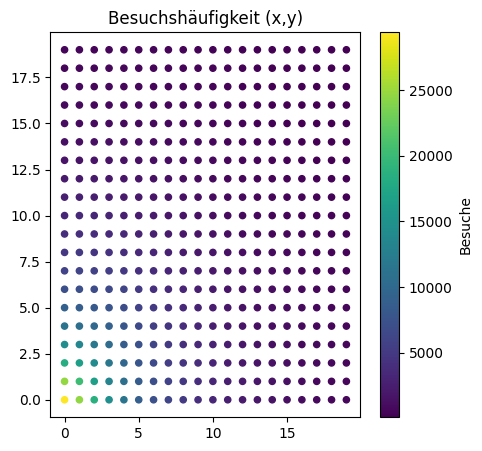

In [4]:
xs, ys, cs = zip(*[(x,y,c) for (x,y),c in visits.items()])
plt.figure(figsize=(5,5))
plt.scatter(xs, ys, c=cs, cmap='viridis', s=20)
plt.colorbar(label='Besuche')
plt.title('Besuchshäufigkeit (x,y)')
plt.show()
